### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
import xgboost as xgb
import pickle
import warnings

warnings.filterwarnings(action='ignore')

c:\Users\aashi\Desktop\Personal Projects\Data Science\Identifying-Faulty-Water-Pumps-With-Machine-Learning\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [3]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [4]:
# check that all rows were in the joined dataset
len(df) == len(train_label) == len(train_values)

True

In [5]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
# search for duplicates 
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [7]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['column', 'number of missing values']
missing[missing['number of missing values']>0]

,column,number of missing values
3,funder,3637
5,installer,3655
8,wpt_name,2
11,subvillage,371
18,public_meeting,3334
20,scheme_management,3878
21,scheme_name,28810
22,permit,3056


### Feature Engineering

#### Remove Irrelevant Fields

In [8]:
# uneeded columns (fields that don't help predict the target label)
unneeded_col = ['id', 'recorded_by', 'wpt_name']
df = df.drop(unneeded_col, axis=1)

#### Handle Fields with Too Many Unique Values

In [9]:
# get all categorical variables
df['region_code'] = df['region_code'].astype('object')
df['district_code'] = df['district_code'].astype('object')

# get categorical variables
cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count_df = pd.DataFrame(col_count.items())
col_count_df.columns = ['Field', 'Number of Unique Values']
col_count_df.head()

,Field,Number of Unique Values
0,date_recorded,356
1,funder,1896
2,installer,2145
3,basin,9
4,subvillage,19287


In [10]:
# remove redundant data (fields with information provided in other columns)
redundant_col = ['subvillage','latitude', 'longitude', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'waterpoint_type', 'management']
df = df.drop(redundant_col, axis=1)

#### Handle Date Values

In [11]:
# derive age of water pump (i.e., years since construction)
df['construction_year'] = pd.to_datetime(df['construction_year'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['age'] = (df['date_recorded'] - df['construction_year']) / np.timedelta64(1, 'Y')

# delete construction_year and date_recorded columns 
df = df.drop(['construction_year', 'date_recorded'], axis=1)

#### Testing Numerical Features With ANOVA

In [12]:
# get quantifiable variables
num_var = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_var

['amount_tsh', 'gps_height', 'num_private', 'population', 'age']

Text(0.5, 1.0, 'P-value of Each Feature')

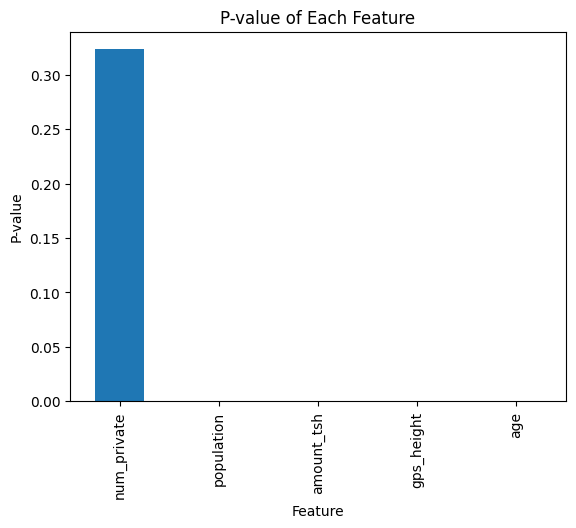

In [14]:
# copy the dataset for ANOVA test
df_int = df.copy(deep=True)

# keep the numerical columns and the target label
int_var = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']] + ['status_group']
df_int = df_int[int_var]

# get the input and output variables
X = df_int.drop('status_group', axis=1)
y = df_int['status_group']

# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(X, y)

# compute the p-values for each F-statistic
p_values = {col: np.round(p_value, 4) for col, p_value in zip(X.columns, fit.pvalues_)}

# plot p_values
p_values = pd.Series(p_values.values(),index = p_values.keys())
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()
plt.xlabel('Feature')
plt.ylabel('P-value')
plt.title('P-value of Each Feature')

In [34]:
# remove columns with high p-values from ANOVA test
anova_drop = ['num_private']
df = df.drop(anova_drop, axis=1)

#### Testing Categorical Features With Chi-Square Test

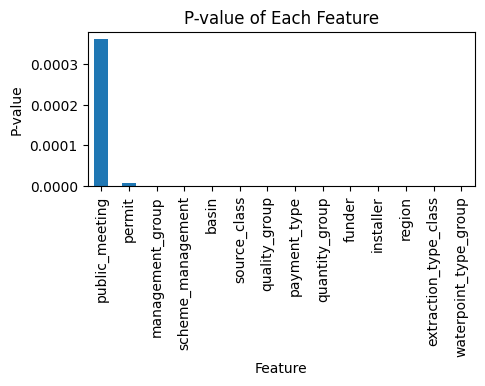

In [18]:
# copy the dataframe for chi square tests
df_chi = df.copy(deep=True)

# keep the categorical variables in the data frame
cat_var = [col for col in df_chi.columns if df[col].dtypes == 'object']
df_chi = df_chi[cat_var]

# encode the categorical variables
label_encoder = LabelEncoder()
for col in df_chi.columns:
    df_chi[col] = label_encoder.fit_transform(df_chi[col])

# get input and output variables
X = df_chi.drop('status_group',axis=1)
y = df_chi['status_group']

# perform chi-square tests
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


# plot the p-values
plt.figure(figsize=(5,2))
p_values.plot.bar()
plt.xlabel('Feature')
plt.ylabel('P-value')
plt.title('P-value of Each Feature')
plt.show()


In [37]:
# see all remaining features
df.columns
df.dtypes

amount_tsh               float64
funder                    object
gps_height                 int64
installer                 object
basin                     object
region                    object
population                 int64
public_meeting            object
scheme_management         object
permit                    object
extraction_type_class     object
management_group          object
payment_type              object
quality_group             object
quantity_group            object
source_class              object
waterpoint_type_group     object
status_group              object
age                      float64
dtype: object

### Creating Training and Testing Sets

In [38]:
# get input and output data
X = df.drop('status_group', axis=1)
y = df['status_group']

# create training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [39]:
X_train.shape

(41580, 18)

In [40]:
X_train.isnull().sum()

amount_tsh                  0
funder                   2548
gps_height                  0
installer                2555
basin                       0
region                      0
population                  0
public_meeting           2297
scheme_management        2733
permit                   2151
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
age                         0
dtype: int64

In [41]:
# encode the target label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [42]:
# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'functional': 0, 'functional needs repair': 1, 'non functional': 2}

### Baseline Models

In [26]:
# train a dummy classifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)

# generate predictions
y_pred_dummy = dummy_clf.predict(X_test)

In [27]:
# Define the column transformer
cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
num_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]

# Define column transformer for one-hot encoding categorical features
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('cat_transformer', categorical_transformer, cat_var)
  # replace missing categorical values with mode and one-hot encode
], remainder='passthrough')

# Define final pipeline with preprocessing and logistic regression model
pipeline_log = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('logistic_regression', LogisticRegression())
])

# fit the data and generate predictions
pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_test)

In [28]:
# derive the f2-scores for each baseline model
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
f2_score_log = fbeta_score(y_test, y_pred_log, average='micro', beta=2)

# print the f-2 score
print(f'F2 score of dummy classifier: {f2_score_dummy}')
print(f'F2 score of logistic regression classifier: {f2_score_log}')

F2 score of dummy classifier: 0.32895622895622895
F2 score of logistic regression classifier: 0.6836139169472503


### CatBoost Model

In [29]:
# create a f2 score metric for hyperparameter tuning
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='weighted')
f2_scorer = make_scorer(f2_score)

In [30]:

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10)
    }

    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Get list of columns with missing values
    cols_with_missing = df.columns[df.isna().any()].tolist()


    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)
    # set up the wrapper with the StandardScaler
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)


    # create a scikit learn pipeline with the transformers and estimator
    pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Other', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])
    
    # Define cross-validation method
    sfk = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_train_df = pd.Series(y_train)

     # Train and evaluate model using f1_score
    f2_scores = []
    for train_idx, test_idx in sfk.split(X_train, y_train_df):
        X_train_split, X_valid_split = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_split, y_valid_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]

        # generate the prediction
        pipeline_cbc.fit(X_train_split, y_train_split)
        y_pred = pipeline_cbc.predict(X_valid_split)

        # add the f2-score to the list
        f2_scores.append(fbeta_score(y_valid_split, y_pred, beta=2, average='micro'))
    # return the mean of the f-2 scores
    return np.mean(f2_scores)

# obtain the optimal hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-05-07 21:35:20,220] A new study created in memory with name: no-name-17a738ff-fd3a-40e9-b939-659b8fd802bd
[I 2023-05-07 21:40:44,091] Trial 0 finished with value: 0.7430014430014431 and parameters: {'learning_rate': 0.011620759671932275, 'iterations': 1000, 'depth': 6}. Best is trial 0 with value: 0.7430014430014431.
[I 2023-05-07 21:43:04,506] Trial 1 finished with value: 0.7401875901875902 and parameters: {'learning_rate': 0.024397983989308272, 'iterations': 700, 'depth': 4}. Best is trial 0 with value: 0.7430014430014431.
[I 2023-05-07 21:46:33,558] Trial 2 finished with value: 0.7160894660894662 and parameters: {'learning_rate': 0.0023029225834446856, 'iterations': 600, 'depth': 6}. Best is trial 0 with value: 0.7430014430014431.
[I 2023-05-07 21:51:55,532] Trial 3 finished with value: 0.7502886002886003 and parameters: {'learning_rate': 0.014636000173060711, 'iterations': 700, 'depth': 8}. Best is trial 3 with value: 0.7502886002886003.
[I 2023-05-07 21:57:18,825] Trial 4 

In [31]:
best_params = study.best_params
# perform one hot encoding on the categorical features

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get list of columns with missing values
cols_with_missing = df.columns[df.isna().any()].tolist()

# sspecify columns for imputer
imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)

# specify columns for standard scaler
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)

# create pipeline
pipeline_cbc = Pipeline(steps=[('impute', SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)),
                            ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)),
                            ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**best_params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])

# fit pipeline
pipeline_cbc.fit(X_train, y_train)



Pipeline(steps=[('impute',
                 SklearnTransformerWrapper(transformer=SimpleImputer(strategy='most_frequent'),
                                           variables=['funder', 'installer',
                                                      'public_meeting',
                                                      'scheme_management',
                                                      'permit'])),
                ('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['amount_tsh',
                                                      'gps_height',
                                                      'population', 'age'])),
                ('rare_label',
                 RareLabelEncoder(replace_with='Unknown',
                                  variables=['funder', 'installer', 'basin',
                                             'region', 'public_meeting',
                                             'scheme_management', 'permit',
                                             'extraction_type_class',
                                             'management_group', 'payment_type',
                                             'quality_group', 'quantity_group',
                                             'source_class',
                                             'waterpoint_type_group'])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000002403E1AEC70>)])

In [32]:
#generate predictions
y_pred_cbc= pipeline_cbc.predict(X_test)
f2_score_cbc = fbeta_score(y_pred_cbc, y_test, beta=2, average='micro')
print(f'F2 score of CatBoost Classifier {f2_score_cbc}')

F2 score of CatBoost Classifier 0.7854096520763187


### LightGBM Clasifier

In [30]:

def objective(trial):

    global X_train, X_test, y_train, y_test

    def f2_score(y_true, y_pred):
        return fbeta_score(y_true, y_pred, beta=2, average='weighted')
    f2_scorer = make_scorer(f2_score)


    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'max_depth': trial.suggest_int('max_depth', 4, 12)
    }

    num_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes in ['float64', 'int64']]
    cat_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    cols_with_missing = df.columns[df.isna().any()].tolist()


    X_cat = X_train.copy(deep=True)
    X_test_cat = X_test.copy(deep=True)

    for col in cat_cols:
        X_cat[col] = X_cat[col].astype('category')
        X_test_cat[col] = X_test_cat[col].astype('category')

    y_train_df = pd.Series(y_train)

    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)
    # specify columns for standard scaler
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)

    # create lgbm classifier
    lgb_model = lgb.LGBMClassifier(**params, 
                            metric='multi_logloss',
                            categorical_feature=cat_indices)


    skf = StratifiedKFold(n_splits=3, random_state=43, shuffle=True)
    f2_scores = []

    
    # perform stratified splits
    for idx, (train_idx, test_idx) in enumerate(skf.split(X_cat, y_train_df)):
        X_train_split, X_valid_split = X_cat.iloc[train_idx], X_cat.iloc[test_idx]
        y_train_split, y_valid_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]
        
        # create pipeline
        pipeline = Pipeline(steps=[('scaler', scaler),
                                   ('lgb_model', lgb_model)])
        # fit the pipeline
        pipeline.fit(X_train_split, 
                     y_train_split, 
                     lgb_model__early_stopping_rounds=50,
                     lgb_model__eval_set=[(X_valid_split, y_valid_split)], 
                     lgb_model__verbose=False)
        
        # generate predictions
        y_pred = pipeline.predict(X_valid_split)

        # add f-2 score to the list
        f2_score_lgbm = fbeta_score(y_valid_split, y_pred, beta=2, average='micro')
        f2_scores.append(f2_score_lgbm)

    # return mean f-2 score
    return np.mean(f2_scores)
    
# perform study
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=50)

[I 2023-05-07 19:28:51,777] A new study created in memory with name: no-name-9c055099-b724-4ab6-9857-e5b020e3619d
[I 2023-05-07 19:28:57,071] Trial 0 finished with value: 0.7480038480038481 and parameters: {'learning_rate': 0.010641457943350977, 'num_leaves': 75, 'max_depth': 8}. Best is trial 0 with value: 0.7480038480038481.
[I 2023-05-07 19:29:02,270] Trial 1 finished with value: 0.7712361712361714 and parameters: {'learning_rate': 0.06594652295940988, 'num_leaves': 135, 'max_depth': 8}. Best is trial 1 with value: 0.7712361712361714.
[I 2023-05-07 19:29:06,287] Trial 2 finished with value: 0.7672438672438672 and parameters: {'learning_rate': 0.06353046068843841, 'num_leaves': 187, 'max_depth': 7}. Best is trial 1 with value: 0.7712361712361714.
[I 2023-05-07 19:29:09,391] Trial 3 finished with value: 0.7637085137085138 and parameters: {'learning_rate': 0.07236602116477306, 'num_leaves': 26, 'max_depth': 9}. Best is trial 1 with value: 0.7712361712361714.
[I 2023-05-07 19:29:11,664]

In [33]:
best_params_lgbm = study_lgbm.best_params


num_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes in ['float64', 'int64']]
cat_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
cols_with_missing = df.columns[df.isna().any()].tolist()


X_cat = X_train.copy(deep=True)
X_test_cat = X_test.copy(deep=True)

for col in cat_cols:
    X_cat[col] = X_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')

y_train_df = pd.Series(y_train)


# specify columns for standard scaler
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)

lgb_model = lgb.LGBMClassifier(**best_params_lgbm, 
                        metric='multi_logloss',
                        categorical_feature=cat_indices)


pipeline_lgbm = Pipeline(steps=[
                            ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), 
                                                                 variables=num_cols)),
                            ('lgb_model', lgb_model)])
#model = lgb.LGBMClassifier(**params, categorical_feature=cat_indices)
pipeline_lgbm.fit(X_cat, 
                y_train, 
                lgb_model__early_stopping_rounds=50,
                lgb_model__eval_set=[(X_test_cat, y_test)], 
                lgb_model__verbose=False)

Pipeline(steps=[('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['amount_tsh',
                                                      'gps_height',
                                                      'population', 'age'])),
                ('lgb_model',
                 LGBMClassifier(categorical_feature=[1, 3, 4, 5, 7, 8, 9, 10,
                                                     11, 12, 13, 14, 15, 16],
                                learning_rate=0.04602640494497168, max_depth=12,
                                metric='multi_logloss', num_leaves=189))])

In [50]:
y_pred_lgbm = pipeline_lgbm.predict(X_test_cat)
f2_score_lgbm = fbeta_score(y_test, y_pred_lgbm, beta=2, average='micro')
print(f'F2 score of LGBM Classifier: {f2_score_lgbm}.')

F2 score of LGBM Classifier: 0.7896745230078563.


### XGBoost 

In [35]:
 # define the objective function for Optuna to minimize
def objective(trial):

    # define hyperparameters to tune with Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1)
    }
    
    # Define the column transformer
    cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
    num_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]

    # Define column transformer for one-hot encoding categorical features
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Define column transformer for scaling numeric features
    numerical_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Define preprocessing pipeline
    preprocessing_pipeline = ColumnTransformer([
        ('cat_transformer', categorical_transformer, cat_var),
        ('num_transformer', numerical_transformer, num_var)
    # replace missing categorical values with mode and one-hot encode
    ], remainder='passthrough')


    # create an XGBoost classifier
    xgb_model = xgb.XGBClassifier(**params, 
                                objective='multi:softmax', 
                                eval_metric='mlogloss',
                                seed=42)

    # Define final pipeline with preprocessing and logistic regression model
    pipeline_xgb= Pipeline([('preprocessing', preprocessing_pipeline)])
    y_train_df = pd.Series(y_train)
    


    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    f2_scores = []

    # perform stratified split
    for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train_df)):
        X_train_split, X_valid_split = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_split, y_valid_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]
    
        # transform input data
        X_train_split = pipeline_xgb.fit_transform(X_train_split)
        X_test_split = pipeline_xgb.transform(X_valid_split)

        # fit the data
        xgb_model.fit(X_train_split, y_train_split,
                      eval_set=[(X_valid_split, y_valid_split)],
                      early_stopping_rounds=50,
                      verbose=False)
        
        # generate predictions
        y_pred = xgb_model.predict(X_valid_split)

        # add f-2 score to the list
        f2_score_xgb = fbeta_score(y_valid_split, y_pred, beta=2, average='micro')
        f2_scores.append(f2_score_xgb)

    # return mean of f-2 scores
    return np.mean(f2_scores)

# create an Optuna study
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2023-05-07 19:38:37,248] A new study created in memory with name: no-name-f5f6cec1-9a76-498f-9f0b-37a6f027a103
[I 2023-05-07 19:39:09,149] Trial 0 finished with value: 0.7855218855218856 and parameters: {'n_estimators': 300, 'max_depth': 10, 'gamma': 0.6349316581945026, 'subsample': 0.595881508338057, 'colsample_bytree': 0.7389369882385136, 'learning_rate': 0.178684929220419}. Best is trial 0 with value: 0.7855218855218856.
[I 2023-05-07 19:39:25,184] Trial 1 finished with value: 0.7733285233285234 and parameters: {'n_estimators': 200, 'max_depth': 4, 'gamma': 0.5987444346178139, 'subsample': 0.6729697474090099, 'colsample_bytree': 0.8535591341220928, 'learning_rate': 0.8021334631096653}. Best is trial 0 with value: 0.7855218855218856.
[I 2023-05-07 19:39:32,584] Trial 2 finished with value: 0.7613997113997114 and parameters: {'n_estimators': 100, 'max_depth': 4, 'gamma': 0.43969308518980665, 'subsample': 0.586669343041767, 'colsample_bytree': 0.6701564114684582, 'learning_rate': 0.

In [46]:
# get best parameters
best_params_xgb = study_xgb.best_params

# Define the column transformer
cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
num_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]

# Define column transformer for one-hot encoding categorical features
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define column transformer for scaling numeric features
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Define preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('cat_transformer', categorical_transformer, cat_var),
    ('num_transformer', numerical_transformer, num_var)
# replace missing categorical values with mode and one-hot encode
], remainder='passthrough')


# create an XGBoost classifier
xgb_model = xgb.XGBClassifier(**best_params_xgb, 
                            objective='multi:softmax', 
                            eval_metric='mlogloss',
                            seed=42)

# Define final pipeline with preprocessing and logistic regression model
pipeline_xgb= Pipeline([('preprocessing', preprocessing_pipeline)])
y_train_df = pd.Series(y_train)

# transform data
X_train_xgb = pipeline_xgb.fit_transform(X_train)
X_test_xgb = pipeline_xgb.transform(X_test)

# fit the model
xgb_model.fit(X_train_xgb, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.670726369939647, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.65297307591977, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18903976053222393,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [49]:
# generate predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# compute f-2 score
f2_score_xgb = fbeta_score(y_test, y_pred_xgb, beta=2, average='micro')
print(f'F2 score of XGBoost Classifier: {f2_score_xgb}.')

F2 score of XGBoost Classifier: 0.798989898989899.


### Save the Best Model

In [117]:
# save the training and testing data 
with open('models/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('models/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('models/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('models/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [53]:
# Save the best preprocessing pipeline 
with open('models/xgb_preprocessing.pkl', 'wb') as f:
    pickle.dump(pipeline_xgb, f)

# save the best model
with open('models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


1. lack of understanding of variables (hard to address many unique values)
2. Lack of information on business constraints (cost of repairing/replacing a water pump)